# CME 193 — Lecture 10: Intro to the OpenAI API

By the end of this notebook, you should be able to:

- Explain what an API is and what the OpenAI API provides.
- Safely authenticate using an API key.
- Make a basic chat completion request from Python.
- Send images/PDFs to a model (via multimodal inputs or text extraction).
- Compute embeddings for text and use them for fuzzy matching.
- Understand where to go next for RAG, structured outputs, and more.

Note on costs and privacy:
- API calls may incur cost; keep prompts short, and run selectively in class.
- Treat API keys as secrets. Do not commit, screenshot, or share them.
- Avoid sending sensitive/private data to third-party APIs.

## 1. What is an API? What is the OpenAI API?

- An API is a contract: you send a request, you receive a response.
- "Model as a service": you send text/data, the service returns model output.
- OpenAI API supports:
  - Chat (text) and multimodal (image + text) understanding
  - Embeddings for search & similarity
  - Image generation, audio, tools/agents (beyond this intro)

We will focus on: chat, files (images/PDFs via multimodal or text extraction), and embeddings.

## 2. Accounts, API Keys, and Data Handling

- You need:
  - An OpenAI account and an API key
  - A Python environment with the `openai` SDK
- API key practices:
  - Never hard-code keys in notebooks that may be shared
  - Prefer environment variables (e.g., `OPENAI_API_KEY`) or a local `.env`
  - Add `.env` to `.gitignore`; revoke/regenerate if a key leaks
- Data handling:
  - Minimize sending sensitive data to third-party APIs
  - For classwork, assume anything you send is public at the class level

In [8]:
# Setup: install and import
%pip -q install openai python-dotenv pypdf numpy pandas matplotlib scikit-learn tqdm

import os
from typing import List

from dotenv import load_dotenv
load_dotenv(override=False)  # Load .env if present

# The OpenAI Python SDK (>=1.0)
from openai import OpenAI

# Quick sanity check for the API key
api_key = os.getenv("OPENAI_API_KEY")
if api_key:
    print("OPENAI_API_KEY found in environment.")
else:
    print("WARNING: OPENAI_API_KEY not set. Set it via environment or a local .env file.")

# A helper to get a client (picks up key from environment)
client = OpenAI()

Note: you may need to restart the kernel to use updated packages.
OPENAI_API_KEY found in environment.


## 3. Basic Chat Completion Example

We will:
- Make a minimal one-shot chat request
- Contrast system vs user messages
- Show a simple multi-turn chat history

In the examples below we call `client.chat.completions.create(...)`. The most important arguments you will see are:
- `model`: which model to use (e.g., `"gpt-4o-mini"`).
- `messages`: a list of chat turns, each a dict with `role` (`"system"`, `"user"`, `"assistant"`) and `content`.
- `temperature` (and sometimes `top_p`): control randomness vs determinism of the output.
- `max_completion_tokens` (or legacy `max_tokens`): soft upper bound on how many tokens the model may generate.
- Other optional knobs such as `n`, `stop`, `response_format`, and `tools` let you ask for multiple candidates, stop sequences, structured JSON, or tool/function calling.


In [10]:
# 3.1 Minimal one-shot chat completion
resp = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": "Say hello to the CME 193 class."},
    ],
    temperature=0.7,
)
print(resp.choices[0].message.content)

Hello, CME 193 class! I hope you're all ready for an exciting and informative time ahead. If you have any questions or topics you'd like to discuss, feel free to ask. Enjoy your class!


### Temperature controls randomness

Lower temperatures (e.g., `0` or `0.2`) make responses more deterministic, while higher temperatures (e.g., `0.8+`) make the model sample more freely from lower-probability tokens. Only adjust one of `temperature` or `top_p` at a time.

In [20]:
# 3.1a Comparing different temperatures with repeated sampling
prompt = "Suggest a creative name for a pet rabbit in one sentence."
for temp in [0.0, 0.7, 1.2, 2.0]:
    print(f"temperature={temp}:")
    for i in range(3):
        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=temp,
            max_completion_tokens=40,
        )
        print(f"  sample {i+1}: {resp.choices[0].message.content}")
    print()

temperature=0.0:
  sample 1: How about naming your pet rabbit "Thumper McFluffington"?
  sample 2: How about naming your pet rabbit "Thumper McFluffington"?
  sample 3: How about naming your pet rabbit "Thumper McFluffington"?

temperature=0.7:
  sample 1: How about naming your pet rabbit "Thumper McFluffington," for a whimsical touch that captures both its playful spirit and fluffy charm?
  sample 2: How about calling your pet rabbit "Bun Jovi," a playful twist that combines their fluffy charm with a rock star flair?
  sample 3: How about calling your pet rabbit "Hops McFluffington"?

temperature=1.2:
  sample 1: How about naming your pet rabbit "Nibbles McFlufferson"?
  sample 2: How about calling your pet rabbit "Thumper McFluffkins," combining a playful nod to their hopping nature with a whimsical twist?
  sample 3: How about calling your pet rabbit "Nibbles McFluffington"?

temperature=2.0:
  sample 1: Hopscotch Dancer!
  sample 2: How about Voyager Ho proprurt anner-P àsdkHB'at e

### How to choose the temperature?

- **0.0 – 0.3 (deterministic):** Use when you need reproducible answers or grading scripts (e.g., unit tests, formal reasoning). Responses may look repetitive but are stable.
- **0.4 – 0.8 (balanced):** Good default range for most homework helpers or study aids. You still get solid facts, but with some variation in wording.
- **0.9 – 1.3 (creative):** Use for brainstorming, slogans, poems, idea generation. Expect more surprising wording, occasional tangents, and higher variance.
- **> 1.3 (wild):** Only for playful demos. Quality drops quickly because the model samples from very low-probability tokens.

Rule of thumb: start at 0.7, then dial down if answers feel too random or dial up if creativity is needed.

### Having a Closer Look at Log Probabilities (`logprobs`)

Requesting `logprobs=True` asks the API to return, for each generated token, the log of the probability mass that the model assigned to the token it actually chose. These values are **per-token** likelihoods, not an overall "confidence" in the full answer. To translate a log probability into a probability, exponentiate it: `p = exp(logprob)`.


In [15]:
# 3.1.1 Inspecting per-token log probabilities
import math

logprob_resp = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": "List three short facts about Stanford University."},
    ],
    temperature=0,  # deterministic so logprobs are easier to inspect
    max_completion_tokens=60,
    logprobs=True,
)

choice = logprob_resp.choices[0]
print(choice.message.content)
print("\nFirst few tokens with log probabilities:")
for token_info in choice.logprobs.content[:8]:
    token = token_info.token
    logprob = token_info.logprob
    prob = math.exp(logprob)
    print(f"token={token!r:>6}  logprob={logprob: .2f}  prob≈{prob: .2f}")

print("\nNote: these probabilities are per token. There is no single confidence score for the entire answer.")


1. **Founded in 1885**: Stanford University was established by Leland and Jane Stanford in memory of their only child, Leland Stanford Jr., who passed away at a young age.

2. **Location**: The university is located in Stanford, California, near Palo Alto, and

First few tokens with log probabilities:
token=   '1'  logprob=-0.79  prob≈ 0.45
token=   '.'  logprob= 0.00  prob≈ 1.00
token= ' **'  logprob=-0.00  prob≈ 1.00
token='Founded'  logprob=-0.70  prob≈ 0.49
token= ' in'  logprob=-0.01  prob≈ 0.99
token=   ' '  logprob=-0.00  prob≈ 1.00
token= '188'  logprob=-0.00  prob≈ 1.00
token=   '5'  logprob=-0.00  prob≈ 1.00

Note: these probabilities are per token. There is no single confidence score for the entire answer.


In [22]:
choice.logprobs.content

[ChatCompletionTokenLogprob(token='1', bytes=[49], logprob=-0.7881243228912354, top_logprobs=[]),
 ChatCompletionTokenLogprob(token='.', bytes=[46], logprob=0.0, top_logprobs=[]),
 ChatCompletionTokenLogprob(token=' **', bytes=[32, 42, 42], logprob=-7.743758760625497e-05, top_logprobs=[]),
 ChatCompletionTokenLogprob(token='Founded', bytes=[70, 111, 117, 110, 100, 101, 100], logprob=-0.7044923305511475, top_logprobs=[]),
 ChatCompletionTokenLogprob(token=' in', bytes=[32, 105, 110], logprob=-0.006064009387046099, top_logprobs=[]),
 ChatCompletionTokenLogprob(token=' ', bytes=[32], logprob=-2.2603901015827432e-05, top_logprobs=[]),
 ChatCompletionTokenLogprob(token='188', bytes=[49, 56, 56], logprob=-0.0001584850688232109, top_logprobs=[]),
 ChatCompletionTokenLogprob(token='5', bytes=[53], logprob=-1.9361264946837764e-07, top_logprobs=[]),
 ChatCompletionTokenLogprob(token='**', bytes=[42, 42], logprob=-0.011049000546336174, top_logprobs=[]),
 ChatCompletionTokenLogprob(token=':', byte

### Adding more to the conversation: system prompt and multi-turn chats

- **Message list anatomy:** `messages` is an ordered list of dicts. Each dict has a `role` (`"system"`, `"user"`, `"assistant"`, and sometimes `"tool"`) plus `content`. You send the *entire* list on every request so the model can see the conversation history.
- **System prompt = job description:** The first message usually has `role="system"`. Use it to define persona, tone, safety rules, formatting, etc. Because it is first, the model tends to respect it more than later reminders.
- **User turns vs assistant turns:** `"user"` entries record each question or instruction. After you call the API, append the model's reply as an `"assistant"` message before adding the next user turn. That way the model "remembers" what it already said.
- **Multi-turn workflow in code:**
  1. Start with `[{"role": "system", ...}, {"role": "user", ...}]`.
  2. Send to `client.chat.completions.create(...)`.
  3. Append the response with `messages.append({"role": "assistant", "content": reply})`.
  4. Append the next user question and repeat. This rolling buffer is how follow-up questions get access to prior answers.
- **Keeping context manageable:** Chats can hit the model's context window or rack up costs. Summarize or drop older turns when they are no longer needed, but preserve critical instructions and facts.
- **System prompt refreshers:** If students notice the model drifting, re-state constraints (e.g., "Answer in bullet points") either in the system prompt or by inserting a short reminder before the next user turn.
- **Debug tip:** Print the entire `messages` list when behavior looks odd. Often you'll spot a missing assistant turn or a malformed message that broke the conversation state.

In [33]:
# 3.2 System vs user messages, and a tiny multi-turn example
messages = [
    {"role": "system", "content": "You are a concise teaching assistant for CME 193."},
    {"role": "user", "content": "What is an embedding in one sentence?"},
]

first = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    temperature=1.0,
)
print("Assistant:", first.choices[0].message.content)

Assistant: An embedding is a mapping of discrete objects, such as words or items, into a continuous vector space, enabling the capture of latent relationships and features in a way that preserves semantic similarity.


In [34]:
# Follow-up that relies on prior context
messages.append({"role": "assistant", "content": first.choices[0].message.content})
messages.append({"role": "user", "content": "Give a concrete use-case example in one sentence."})
messages

[{'role': 'system',
  'content': 'You are a concise teaching assistant for CME 193.'},
 {'role': 'user', 'content': 'What is an embedding in one sentence?'},
 {'role': 'assistant',
  'content': 'An embedding is a mapping of discrete objects, such as words or items, into a continuous vector space, enabling the capture of latent relationships and features in a way that preserves semantic similarity.'},
 {'role': 'user',
  'content': 'Give a concrete use-case example in one sentence.'}]

In [ ]:
# note that the assistant is able to retrieve the context from the previous messages (i.e., we are discussing embeddings)
second = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    temperature=1.0,
)
print("Assistant:", second.choices[0].message.content)

Assistant: A concrete use-case example of an embedding is word embeddings like Word2Vec, which allow natural language processing models to understand the semantic relationships between words by representing them as high-dimensional vectors, facilitating tasks such as sentiment analysis or machine translation.


## 4. Structured Outputs (JSON)

Sometimes you want machine-readable results (e.g., a to-do list as JSON). We'll strongly instruct the model and parse the response.
# 7.1 Ask for JSON and parse it
import json

In [79]:

prompt = (
    "Convert the following natural language todo list into JSON with an array of "
    'objects of the form {"task": string, "due_date": string or null}.\n\n'
    "Todo list: Walk the dog today; Finish assignment by Friday; Buy milk;"
)

resp = client.chat.completions.create(
    model="gpt-4o-mini",
    response_format={"type": "json_object"},  # request valid JSON
    messages=[
        {"role": "system", "content": "Return only valid JSON, no extra text."},
        {"role": "user", "content": prompt},
    ],
    temperature=0,
)
raw = resp.choices[0].message.content
print("Raw model output:\n", raw)
try:
    data = json.loads(raw)
    print("\nParsed JSON keys:", list(data.keys()))
    print(json.dumps(data, indent=2)[:800])
except json.JSONDecodeError as e:
    print("Failed to parse JSON:", e)

Raw model output:
 {
  "todos": [
    {
      "task": "Walk the dog",
      "due_date": "today"
    },
    {
      "task": "Finish assignment",
      "due_date": "Friday"
    },
    {
      "task": "Buy milk",
      "due_date": null
    }
  ]
}


NameError: name 'json' is not defined

## 4. Attaching Files: Images & PDFs in a Chat

Two patterns:
- Images: send an image alongside text in a single request (multimodal input)
- PDFs: either use an API that accepts files directly, or extract text locally (e.g., `pypdf`) and include relevant text in the prompt

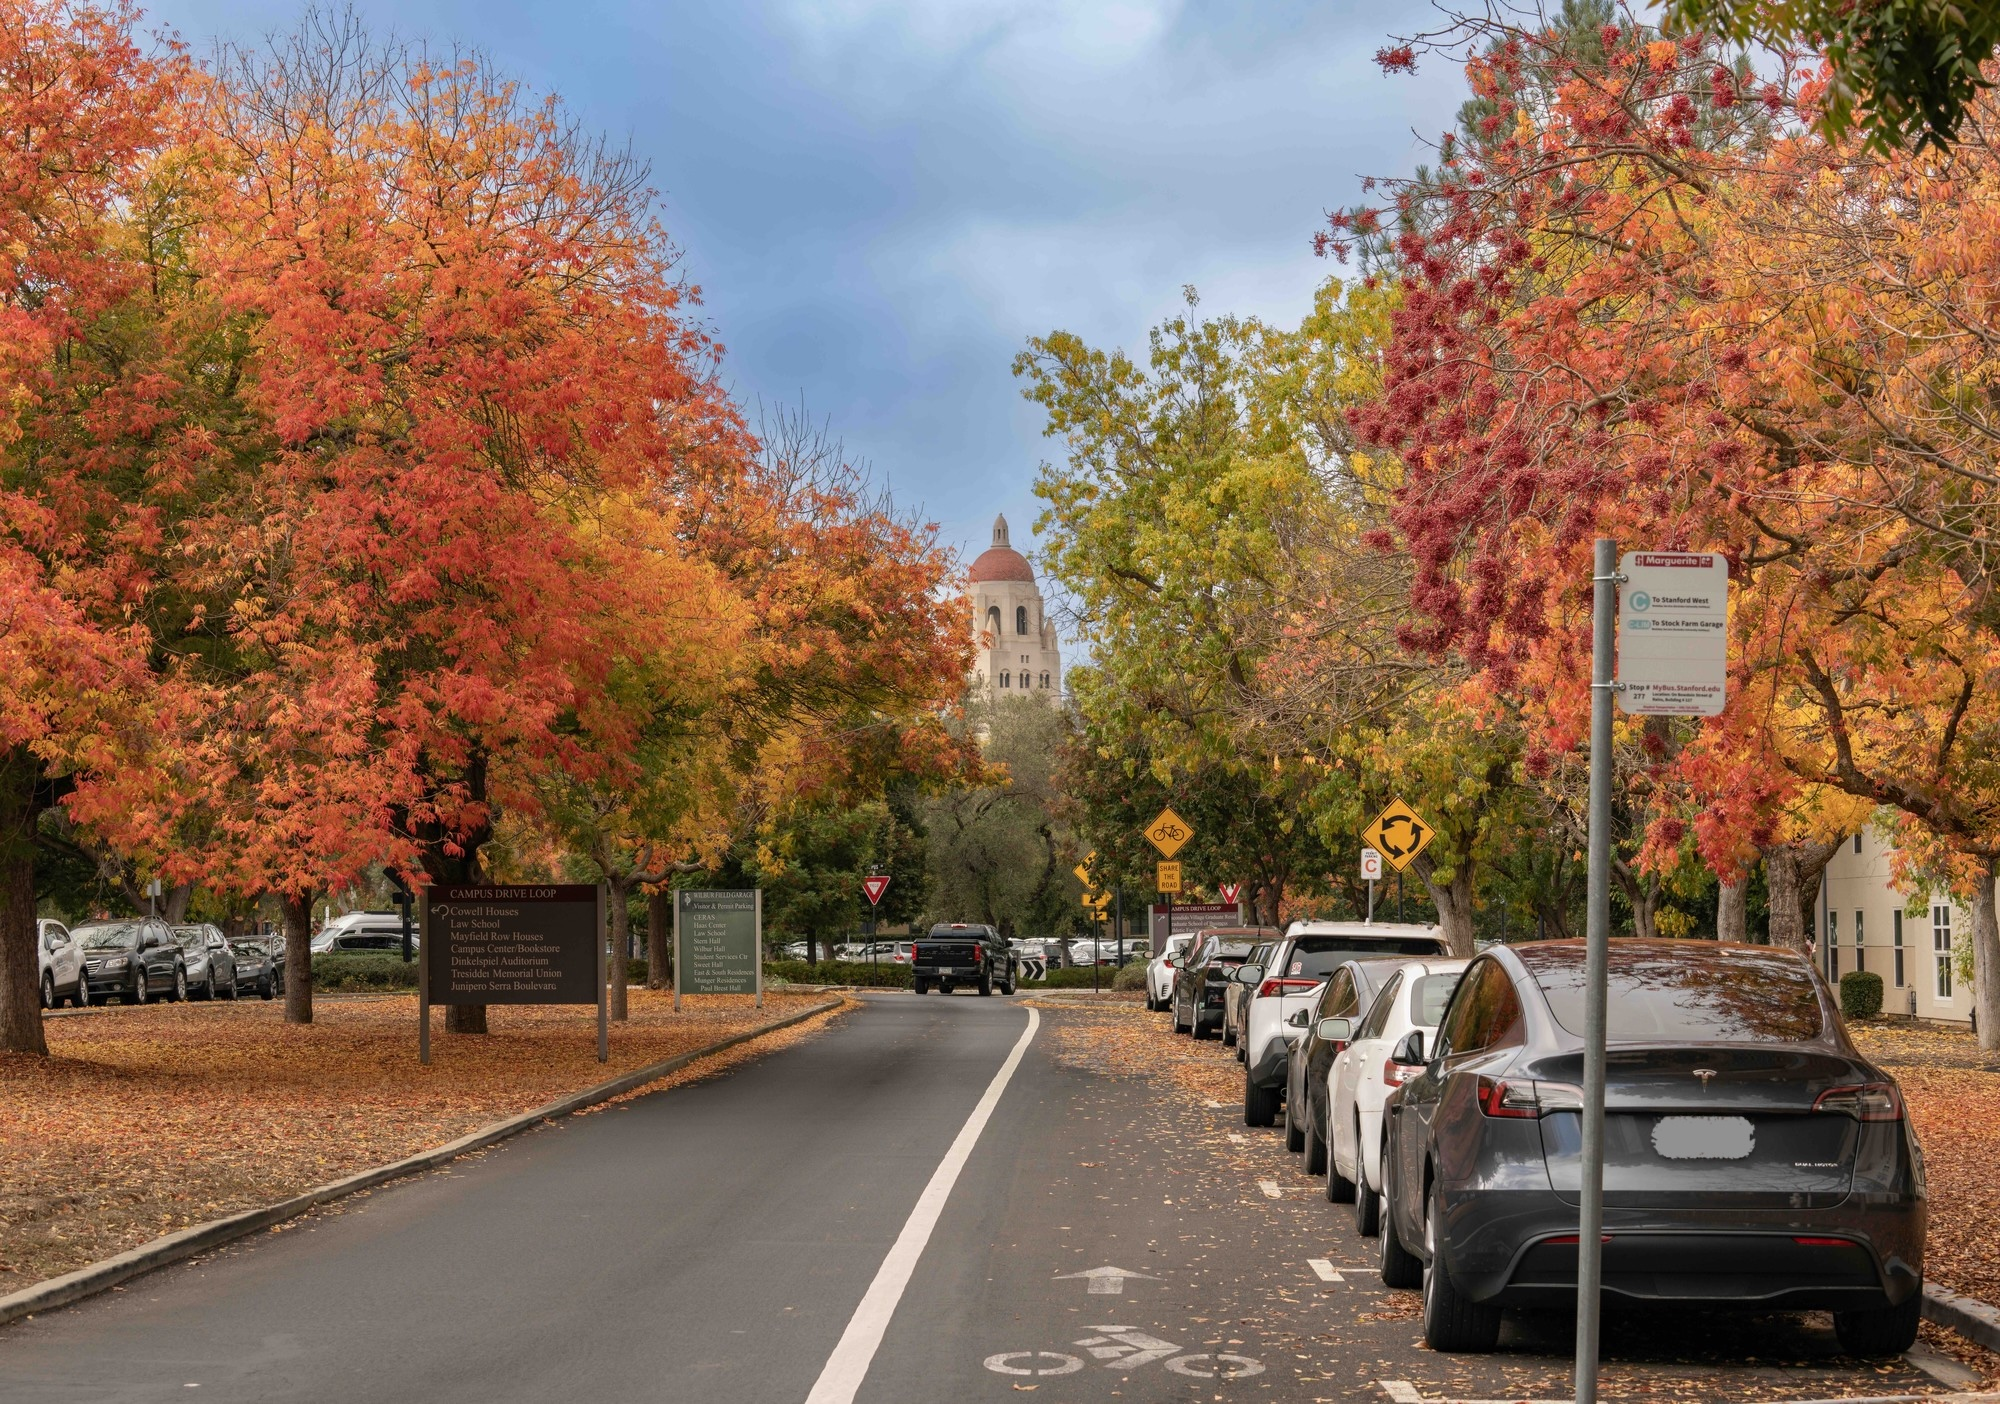

In [49]:
# 4.1 Image understanding with a local image (base64 data URL)
import base64
from pathlib import Path

# Use a sample image included in the repo if available
IMAGE_PATH = Path("DSC03693-Enhanced-SR-small.jpg")
if IMAGE_PATH.exists():
    from IPython.display import Image, display
    display(Image(filename=str(IMAGE_PATH)))

In [50]:
import base64

# Read and base64-encode the image for the Chat Completions API
with IMAGE_PATH.open("rb") as fh:
    image_data = base64.standard_b64encode(fh.read()).decode("utf-8")

# Determine media type from extension
suffix = IMAGE_PATH.suffix.lower()
media_type = "image/png" if suffix == ".png" else "image/jpeg"

In [51]:
# The image data is a base64 encoded string of the image.
print(f"{len(image_data)} characters")
print(image_data[:100])

2031928 characters
/9j/4Q/+RXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMA


# Attach the image to the user message as a multimodal input with type "image_url"

In [52]:
vision_resp = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Describe what's in this image in a few sentences.",
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:{media_type};base64,{image_data}",
                    },
                },
            ],
        }
    ],
    temperature=0.2,
)
print(vision_resp.choices[0].message.content)

The image depicts a scenic street lined with trees showcasing vibrant autumn foliage in shades of orange, yellow, and red. On the left side, there are several parked cars along the curb, while the right side features a bike lane. In the background, a building with a distinctive dome is partially visible, surrounded by greenery. The sky is overcast, adding a soft light to the scene.


## 5. Embeddings: Turning Text Into Vectors

- An embedding is a vector of floats representing text semantics
- Similar texts → similar vectors (small distance / high cosine similarity)
- Use cases: semantic search, clustering/visualization, recommendations, entity resolution

In [ ]:
# 5.1 Minimal embedding API call and inspection
import numpy as np

EMBED_MODEL = "text-embedding-3-small"

Embedding shape: (4, 1536)
First 8 dims of first vector: [-0.0068 -0.0392  0.0342  0.0288 -0.0248 -0.042  -0.0303  0.0493]
cosine(machine learning, deep learning) ≈ 0.655


## Basic Syntax for Creating Embedding for a Single Text

In [56]:
emb = client.embeddings.create(model=EMBED_MODEL, input="Hello, world!")
print(emb.data[0].embedding)

[-0.019143931567668915, -0.025292053818702698, -0.0017211713129654527, 0.01883450709283352, -0.03382139280438423, -0.019682060927152634, -0.02102738246321678, 0.05160655081272125, -0.03218010067939758, -0.03043118305504322, -0.0021508336067199707, -0.028924422338604927, -0.0024871639907360077, -0.03148053586483002, 0.010291713289916515, 0.01856544241309166, -0.04614454507827759, 0.04140901193022728, 0.00043050304520875216, 0.04116685315966606, 0.053651440888643265, 0.0018481360748410225, 0.004564004950225353, 0.009955382905900478, 0.04781274124979973, 0.002164286794140935, -0.00984775647521019, 0.038422394543886185, 0.0009131372789852321, -0.05209086835384369, 0.051122233271598816, -0.032529886811971664, -0.01408552099019289, -0.012605667114257812, 0.013271600939333439, 0.01856544241309166, 0.0016320437425747514, -0.0008479732787236571, -0.012773832306265831, -0.029677802696824074, -0.004510191734880209, -0.015309764072299004, 0.02566874399781227, 0.009047290310263634, -0.0368349142372

In [57]:
print("Embedding shape:", np.array(emb.data[0].embedding).shape)

Embedding shape: (1536,)


## Batch Embedding for Multiple Texts

In [58]:
texts = [
    # Machine learning concepts
    "machine learning",
    "deep learning",
    "neural network",
    "gradient descent",
    "backpropagation",
    "convolutional neural network",
    "recurrent neural network",
    "transformer architecture",
    # Scientific computing concepts
    "numerical integration",
    "finite element method",
    "linear algebra",
    "differential equations",
    "Monte Carlo simulation",
    "matrix factorization",
    "eigenvalue decomposition",
    "sparse matrix computation",
    # Fruits
    "banana",
    "apple",
    "orange",
    "strawberry",
    "mango",
    "pineapple",
    "watermelon",
    "blueberry",
]

# Batch embedding: pass the entire list of texts in a single API call
# The API handles batching internally and returns embeddings in the same order
emb_response = client.embeddings.create(model=EMBED_MODEL, input=texts)

In [62]:
print(f"{len(emb_response.data)} embeddings.")
print(f"Shape of the first embedding: {np.array(emb_response.data[0].embedding).shape}")
print(f"First embedding: {emb_response.data[0].embedding[:10]}...")

24 embeddings.
Shape of the first embedding: (1536,)
First embedding: [-0.012126085348427296, -0.011351445689797401, 0.002754438668489456, -0.047455597668886185, 0.03367893397808075, 0.004483969882130623, 0.004346918314695358, 0.03286854177713394, -0.019079962745308876, 0.022833984345197678]...


In [63]:
# Put the embeddings into a numpy array.
vectors = np.array([d.embedding for d in emb_response.data])
print("Embedding shape:", vectors.shape)  # (n_texts, dim)
print("First 8 dims of first vector:", np.round(vectors[0][:8], 4))

Embedding shape: (24, 1536)
First 8 dims of first vector: [-0.0121 -0.0114  0.0028 -0.0475  0.0337  0.0045  0.0043  0.0329]


## Compute Similarity betweeen Emebddings

<mark>TODO</mark>: add detailed description here (e.g., theory, API, intuition.)

In [66]:
# A small cosine similarity helper
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    a_norm = a / np.linalg.norm(a)
    b_norm = b / np.linalg.norm(b)
    return float(a_norm @ b_norm)

# If real vectors exist, show a quick similarity example
sim = cosine_similarity(vectors[1], vectors[2])  # ml vs dl
print("cosine(machine learning, deep learning) ≈", round(sim, 3))

cosine(machine learning, deep learning) ≈ 0.525


## Clustermap (Heatmap) of Similarity Matrix
<mark>TODO</mark>: add detailed description here (e.g., theory, API, intuition.)

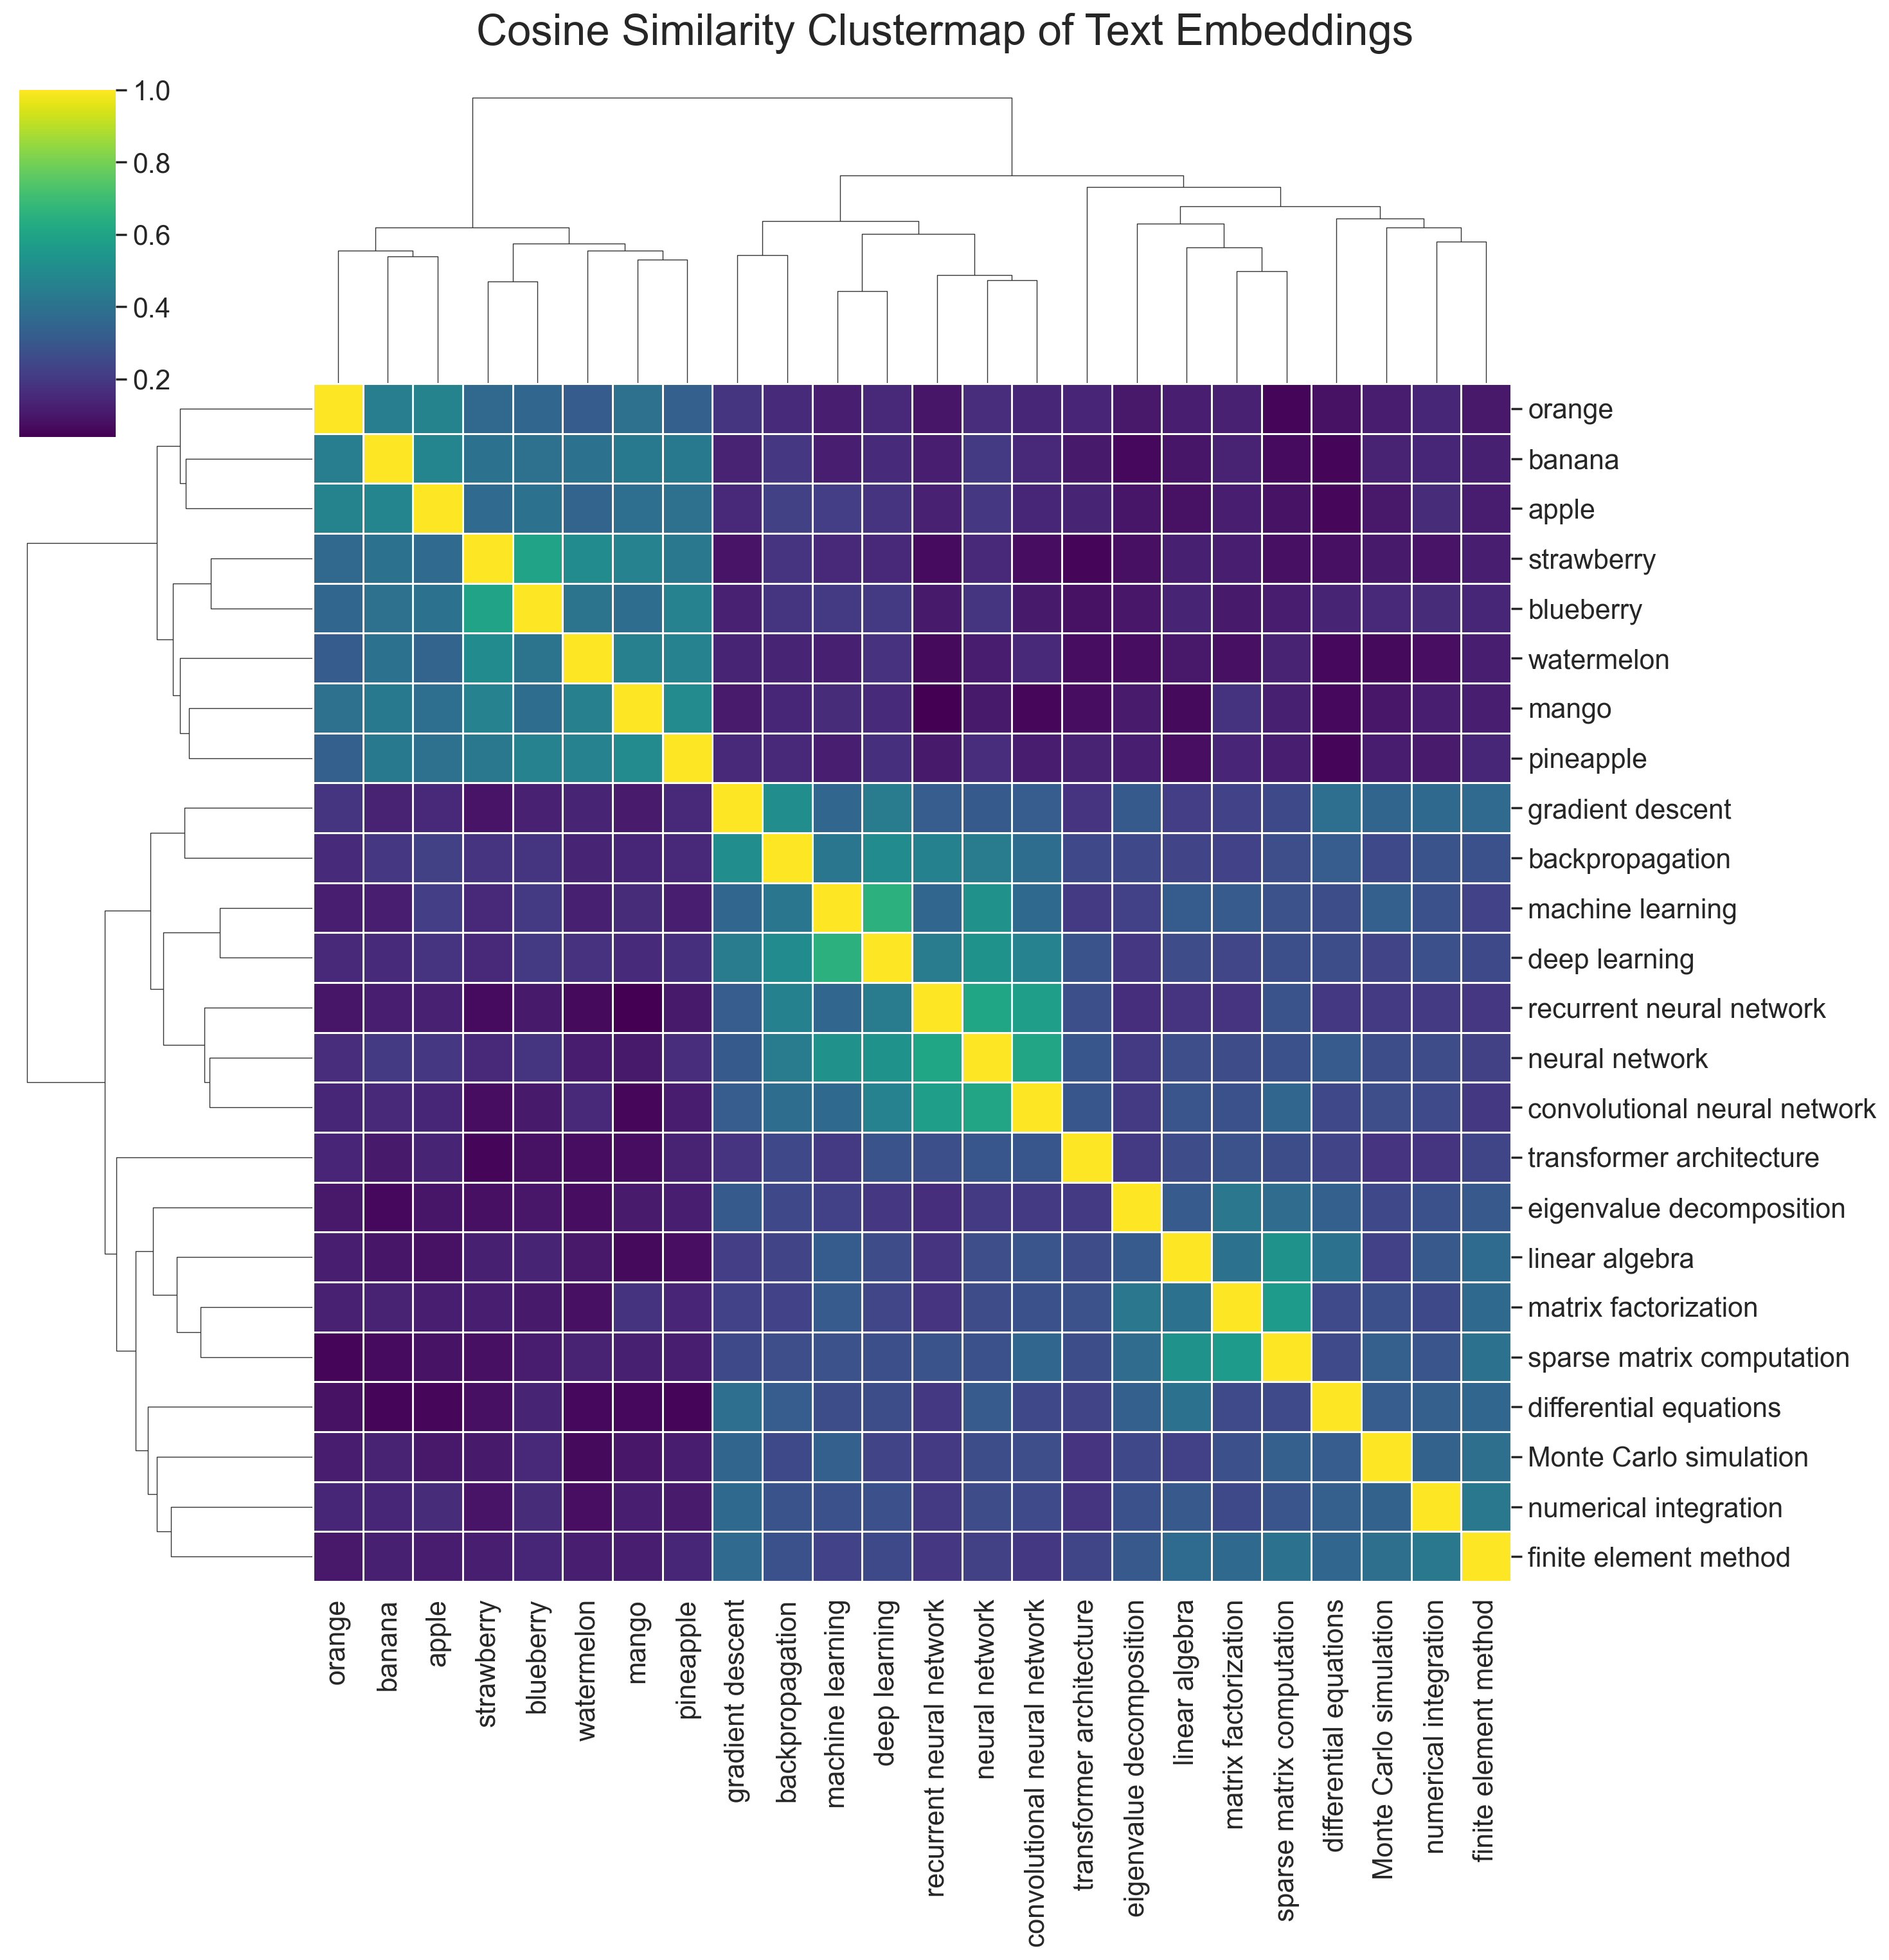

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the full similarity matrix
sim_matrix = np.zeros((len(texts), len(texts)))
for i in range(len(texts)):
    for j in range(len(texts)):
        sim_matrix[i, j] = cosine_similarity(vectors[i], vectors[j])

# Increase font size for classroom presentation
plt.rcParams.update({'font.size': 16})
sns.set(font_scale=1.4)

# Draw clustermap using seaborn with increased DPI and figure size
g = sns.clustermap(
    sim_matrix,
    xticklabels=texts,
    yticklabels=texts,
    cmap="viridis",
    figsize=(15, 15),
    annot=False,
    linewidths=0.5,
)
g.fig.set_dpi(200)
g.fig.suptitle("Cosine Similarity Clustermap of Text Embeddings", y=1.02, fontsize=24)
plt.show()


## Observation:
<mark>TODO</mark>: add observaions from the image.

## TSNE Plot for Visualization of Embeddings
<mark>TODO</mark>: add detailed description here (e.g., theory, API, intuition.)

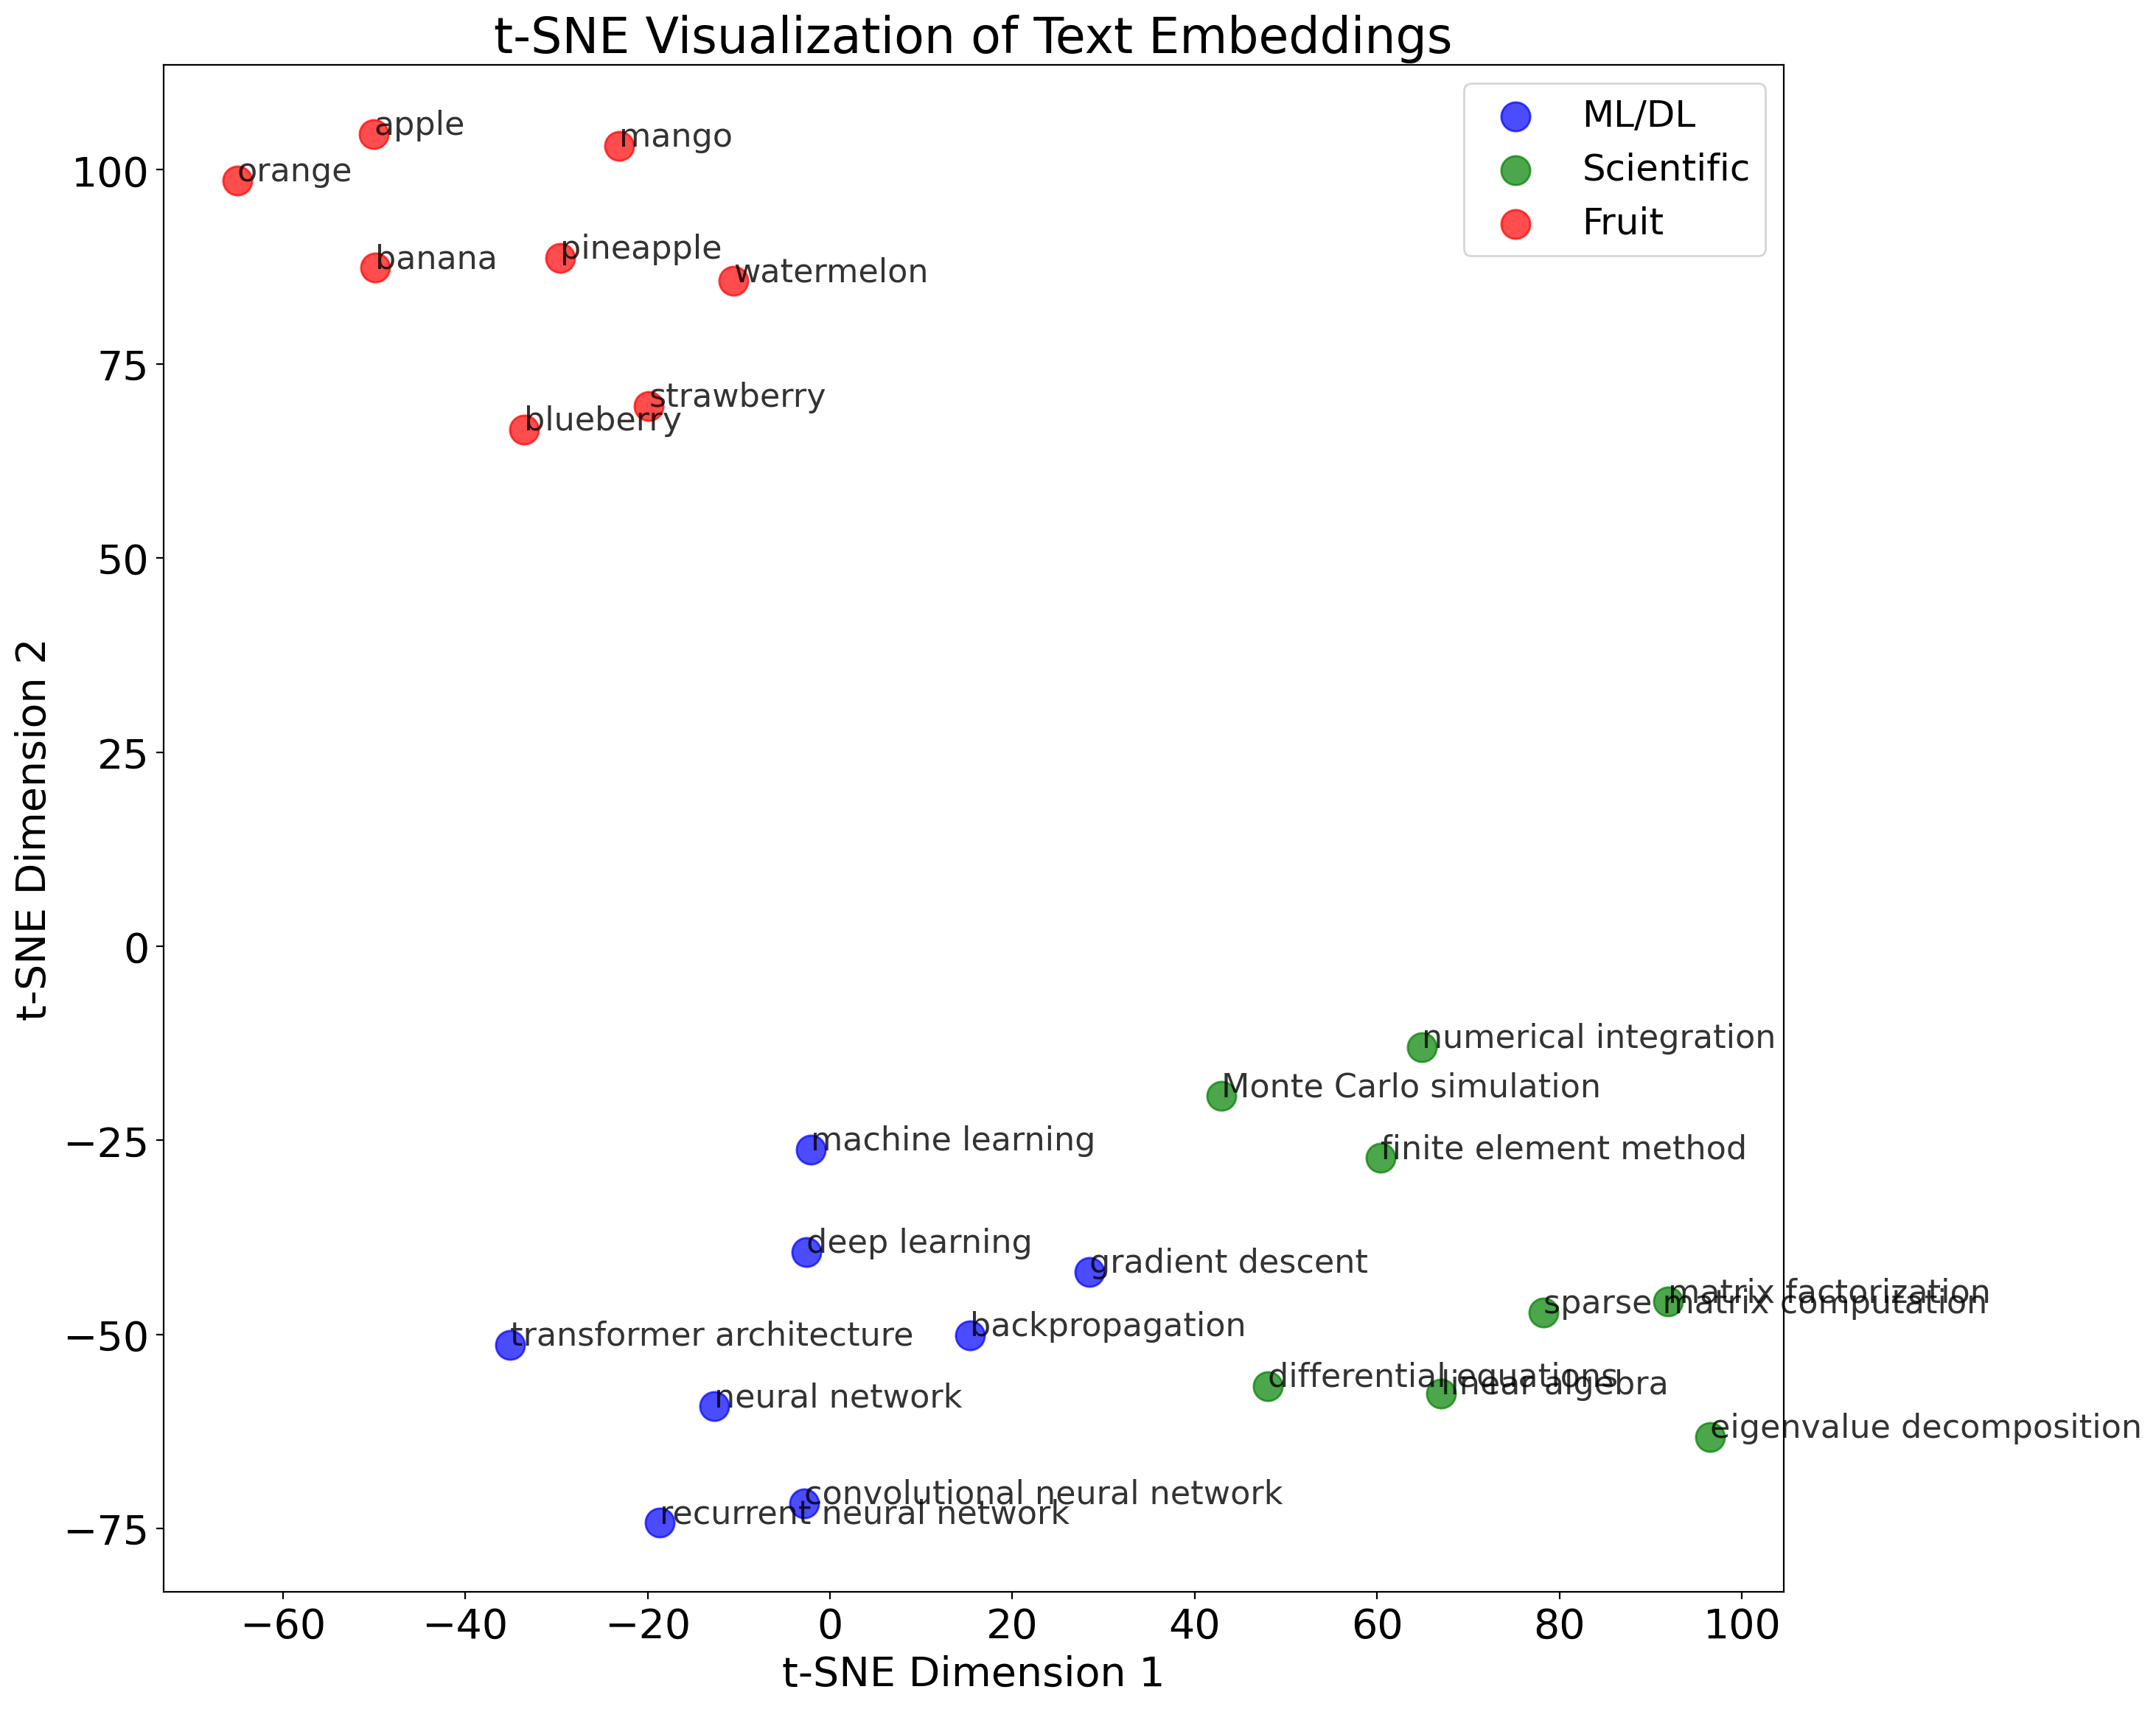

In [73]:
# Visualize embeddings with t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=8)
vectors_2d = tsne.fit_transform(vectors)

# Create labels for coloring by category
categories = (
    ["ML/DL"] * 8 +      # machine learning concepts
    ["Scientific"] * 8 +  # scientific computing concepts
    ["Fruit"] * 8         # fruits
)

# Plot with increased DPI and font size for classroom presentation
plt.figure(figsize=(15, 12), dpi=200)
plt.rcParams.update({'font.size': 20})
colors = {"ML/DL": "blue", "Scientific": "green", "Fruit": "red"}

for cat in colors:
    mask = [c == cat for c in categories]
    pts = vectors_2d[mask]
    plt.scatter(pts[:, 0], pts[:, 1], c=colors[cat], label=cat, s=200, alpha=0.7)

# Annotate points with text labels
for i, txt in enumerate(texts):
    plt.annotate(txt, (vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=16, alpha=0.8)

plt.title("t-SNE Visualization of Text Embeddings", fontsize=24)
plt.xlabel("t-SNE Dimension 1", fontsize=20)
plt.ylabel("t-SNE Dimension 2", fontsize=20)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()


## Observation:
<mark>TODO</mark>: add observaions from the image.

## 6. Fuzzy Matching University Names with Embeddings

Goal: Map messy, self‑reported affiliations (typos/abbreviations) to a canonical list of university names.

Approach:
1) Compute embeddings for canonical names (batch)
2) For each reported affiliation, embed and compute cosine similarity to all canonical vectors


<mark>TODO</mark>: add a concrete motiving example (e.g., you are a hiring recruiter and want to match candidates' reported affiliations (on their resume) to the canonical list of university names in the recruiting system).
<mark>TODO</mark>: add mathematical description here.

In [76]:
# 6.1 Canonical list of university names
school_names_in_system = [
    "Massachusetts Institute of Technology",
    "Stanford University",
    "Harvard University",
    "California Institute of Technology",
    "Princeton University",
    "Yale University",
    "University of Chicago",
    "Columbia University",
    "University of Pennsylvania",
    "Duke University",
    "Northwestern University",
    "Johns Hopkins University",
    "Cornell University",
    "University of California, Berkeley",
    "University of California, Los Angeles",
    "University of Michigan",
    "Carnegie Mellon University",
    "New York University",
    "Brown University",
    "University of Southern California",
    "University of Virginia",
    "Georgetown University",
    "University of North Carolina at Chapel Hill",
    "University of Florida",
    "University of Texas at Austin",
    "Boston University",
    "University of Wisconsin-Madison",
    "University of Illinois Urbana-Champaign",
    "Georgia Institute of Technology",
    "Rice University",
]

print(f"Using canonical list with {len(school_names_in_system)} university names.")

Using canonical list with 30 university names.


In [78]:
import pandas as pd
reported_affiliations = [
    "MIT",
    "Stanford Univ.",
    "Harvard U",
    "Cal Tech",
    "Princton",
    "Yale Univeristy",
    "U Chicago",
    "Columbia Uni.",
    "UPenn",
    "Duke Univ, Durham",
]

pd.DataFrame({"reported_affiliation": reported_affiliations})

,reported_affiliation
0,MIT
1,Stanford Univ.
2,Harvard U
3,Cal Tech
4,Princton
5,Yale Univeristy
6,U Chicago
7,Columbia Uni.
8,UPenn
9,"Duke Univ, Durham"


In [82]:
# 6.2 Batch-embed canonical names, then match reported affiliations
from typing import List, Tuple

can_emb_resp = client.embeddings.create(
    model=EMBED_MODEL,
    input=school_names_in_system,
)
canonical_vectors = np.array([item.embedding for item in can_emb_resp.data])
canonical_vectors_norm = canonical_vectors / np.linalg.norm(
    canonical_vectors, axis=1, keepdims=True
)
print("Canonical embeddings shape:", canonical_vectors.shape)


def embed_text(text: str) -> np.ndarray:
    resp = client.embeddings.create(model=EMBED_MODEL, input=[text])
    return np.array(resp.data[0].embedding)


def find_top_matches(query: str, top_k: int = 3) -> List[Tuple[str, float]]:
    """Return list of (canonical_name, similarity_score) for top_k matches."""
    q_vec = embed_text(query)
    q_vec = q_vec / np.linalg.norm(q_vec)
    sims = canonical_vectors_norm @ q_vec  # cosine similarities
    top_indices = np.argsort(sims)[::-1][:top_k]
    return [(school_names_in_system[i], float(sims[i])) for i in top_indices]


results = []
for aff in reported_affiliations:
    top_matches = find_top_matches(aff, top_k=3)
    for rank, (name, score) in enumerate(top_matches, start=1):
        results.append({
            "reported_affiliation": aff,
            "rank": rank,
            "matched_canonical_name": name,
            "similarity": score,
        })

matches_df = pd.DataFrame(results)
matches_df

Canonical embeddings shape: (30, 1536)


,reported_affiliation,rank,matched_canonical_name,similarity
0,MIT,1,Massachusetts Institute of Technology,0.623797
1,MIT,2,California Institute of Technology,0.463304
2,MIT,3,Georgia Institute of Technology,0.432200
3,Stanford Univ.,1,Stanford University,0.896482
4,Stanford Univ.,2,"University of California, Berkeley",0.578103
5,Stanford Univ.,3,Harvard University,0.490667
6,Harvard U,1,Harvard University,0.891722
7,Harvard U,2,Yale University,0.623842
8,Harvard U,3,Princeton University,0.607811
9,Cal Tech,1,California Institute of Technology,0.707773


## Observations:
<mark>TODO</mark>: add observations here from the matching results.

# Thank you all for your participation this quarter!
# Attendance Form
![Attendance Form](images/CME193_Lecture_10_Attendance_Form.png)
